MODEL EVALUATION

In [45]:
env = 'colab'  # 'colab' or 'pc'
using_gpu = False  # True or False

saving_metrics_report = True
saving_train_times = True
saving_histories = True

test_percentage = 0.1

git_download_path = 'https://raw.githubusercontent.com/PashaIanko/Covid19Classifier/model_evaluation/'
# Number of trial for this day (-> directory/24-01-22/trial-{n_trial}/ -- example of directories)

In [46]:
names = ['CNN', 'Dropout']
date_ = '2022-01-29'
n_trial = 2

# Packages & functions

In [47]:
# %%capture
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}


if env == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

    
    files = [
            'DataProperties.py',
            'DatasetParameters.py',
            'Preprocessing.py',
            'PreprocessingParameters.py',
            
            'Model.py',
            'BNModel.py',
            'CNNModel.py',
            'VGG19Model.py',
            'VGG16Model.py',
            'AlexNetModel.py',
            'DropoutModel.py',
            'InceptionModel.py',
            'ResNetModel.py',

            'Utils.py',
            'ModelUtils.py',
            'TimeCallBack.py'
    ]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[:3]}
    download_files(url_dict)

In [49]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[3:6]}
    download_files(url_dict)

In [50]:
%%capture
if env == 'colab':
    url_dict = {file: git_download_path + file for file in files[6:]}
    download_files(url_dict)

In [51]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [52]:
from os.path import isdir
import os
import numpy as np

# Plotting
import seaborn as sns

# Utils
import importlib
from os.path import isdir
from datetime import date
import pandas as pd

# Dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [53]:
import DataProperties 
import PreprocessingParameters 
import Preprocessing
import DatasetParameters
import Utils
import CNNModel
import BNModel
import ResNetModel
import DropoutModel
import InceptionModel
import AlexNetModel
import VGG19Model
import VGG16Model
import Model
import ModelUtils
import TimeCallBack

def reload_all(modules_list):
    for module in modules_list:
        importlib.reload(module)

reload_all(
    [
        DataProperties,
        PreprocessingParameters,
        DatasetParameters,
        Utils,
        Preprocessing,

        Model,
        CNNModel,
        BNModel,
        DropoutModel,
        
        VGG16Model,
        ResNetModel,
        InceptionModel,
        ModelUtils,
        TimeCallBack,
        VGG19Model,
        AlexNetModel
    ]
)

from DataProperties import DataProperties
from PreprocessingParameters import PreprocessingParameters
from DatasetParameters import DatasetParameters
from Utils import *
from Preprocessing import *
from CNNModel import CNNModel
from BNModel import BNModel
from DropoutModel import DropoutModel
from VGG19Model import VGG19Model
from ResNetModel import ResNetModel
from InceptionModel import InceptionModel
from ModelUtils import ModelUtils
from TimeCallBack import TimeCallBack
from AlexNetModel import AlexNetModel
from VGG16Model import VGG16Model

In [54]:
DataProps = DataProperties(
    environment = env,
    n_trial = n_trial
)

# Class balance

## Paths download

In [55]:
assert isdir(DataProps.test_data_path) == True
assert isdir(DataProps.models_path) == True

In [56]:
train_files = calc_files(directory = DataProps.train_data_path)
train_covid_files = calc_files(DataProps.train_covid_path)
train_pn_files = calc_files(DataProps.train_pneumonia_path)
train_healthy_files = calc_files(DataProps.train_healthy_path)

assert train_files == (train_covid_files + train_pn_files + train_healthy_files)

In [57]:
val_files = calc_files(directory = DataProps.val_data_path)
val_covid_files = calc_files(DataProps.val_covid_path)
val_pn_files = calc_files(DataProps.val_pneumonia_path)
val_healthy_files = calc_files(DataProps.val_healthy_path)

assert val_files == (val_covid_files + val_pn_files + val_healthy_files)

In [58]:
test_files = calc_files(DataProps.test_data_path)
test_covid_files = calc_files(DataProps.test_covid_path)
test_pn_files = calc_files(DataProps.test_pneumonia_path)
test_healthy_files = calc_files(DataProps.test_healthy_path)

assert test_files == (test_covid_files + test_pn_files + test_healthy_files)

Text(0, 0.5, 'y')

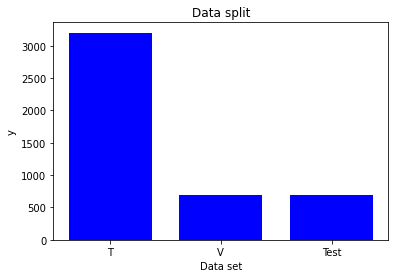

In [59]:
x = ['T', 'V', 'Test']
y = [train_files, val_files, test_files]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ax.bar(x, y, width, color="blue")
plt.title('Data split')
plt.xlabel('Data set')
plt.ylabel('y') 

# Creating test dataset

## Create

In [60]:
test_generator = ImageDataGenerator(
    preprocessing_function = Preprocessing.preprocess,
    validation_split = 1 - test_percentage  # 0.001
)

test_flow = test_generator.flow_from_directory(
    directory = DataProps.test_data_path,
    target_size = PreprocessingParameters.target_shape,
    color_mode = 'rgb',
    classes = DataProperties.classes,
    class_mode = 'sparse',
    shuffle = DatasetParameters.shuffle_test,
    seed = DatasetParameters.seed,
    batch_size = 1,
    subset = 'training'
)

test_steps = test_flow.n // test_flow.batch_size

print(f'Use {test_flow.n} images for test')
print(f'Test steps: {test_steps}')

Found 69 images belonging to 3 classes.
Use 69 images for test
Test steps: 69


## Visualize test dataset

In [61]:
# how_many_to_show = 9
# flow = test_flow
# for _ in range(9):
#     batch, labels = flow.next()
#     print(batch.shape, np.max(batch))
#     assert np.max(batch) <= 1.01
#     assert np.min(batch) >= 0.0
    
#     visualize(
#         batch, 
#         labels, 
#         how_many_to_show, 
#         class_indices = flow.class_indices,
#         figsize=(15, 15)
#     )

## Get_models()

In [62]:
def get_empty_models():
    res = {
        'CNN': CNNModel(name = 'CNN'),
        'VGG19': VGG19Model(name = 'VGG19'),
        'VGG16': VGG16Model(name = 'VGG16'),
        'BN': BNModel(name = 'BN_CNN'),
        'Dropout': DropoutModel(name = 'Dropout'),
        'AlexNet': AlexNetModel(name = 'AlexNet')
    }
    return res
    
def construct_utils(model_name):
    return ModelUtils(

        model_params_dict = dict(**model_params),

        checkpoint_params_dict = dict(
            filepath = f'{DataProps.checkpoint_path}{model_name}/',
            **checkpoint_params
        ),

        train_params_dict = dict(
            **train_params
        )
    )

def get_models(model_names):
    empty_models = get_empty_models()
    empty_model_names = list(empty_models.keys())
    res = {}

    for name in model_names:
        assert name in empty_model_names
        model = empty_models[name]
        utils = construct_utils(name)

        res.update(
            {
                name: {
                    'model': model,
                    'utils': utils
                }
            }
        )
    return res

In [63]:
train_params = dict(
    train_flow = None, # no need here
    train_steps = None, # no need here
    val_flow = None, # no need here
    val_steps = None, # no need here
    epochs = None  # no need here
)

model_params = dict(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['acc'] 
)

checkpoint_params = dict(
    save_freq = 'epoch',
    save_weights_only = True,
    save_best_only = False,
    verbose = 1
)

In [64]:
if using_gpu:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        print(
            '\n\nThis error most likely means that this notebook is not '
            'configured to use a GPU.  Change this in Notebook Settings via the '
            'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
        raise SystemError('GPU device not found')

# Models evaluation

## Models reload

In [65]:
def reload_models(names, directory):
    res_dict = {}
    models = get_models(names)
    for name, model_parameters in models.items():
    
        model = model_parameters['model']
        utils = model_parameters['utils']
        
        model.construct_model()
        model.compile_model(**utils.model_params_dict)
        load_dir = f'{directory}{model.name}/{model.name}.h5'
    
        model.model.load_weights(load_dir)
        res_dict[name] = model
    
    return res_dict

In [66]:
evaluation_path = f'{DataProps.core_path}{date_}/trial-{n_trial}/'
models = reload_models(names, directory = evaluation_path)

## Summaries

In [67]:
empty_models = get_models(names)
for name in names:
    print(f'\nPrinting summary of {name}')
    print_summary(empty_models, name)


Printing summary of CNN
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 150, 150, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin 

## Reload history and training time

In [68]:
training_time_path = f'{DataProps.core_path}{date_}/trial-{n_trial}/'
evaluation_path = f'{DataProps.core_path}{date_}/trial-{n_trial}/'


In [69]:
training_time_df = pd.read_csv(
    f'{evaluation_path}training_time.csv'
)
training_time_df = training_time_df.apply(lambda x: pd.Series(x.dropna().values)).fillna('')

In [70]:
training_time_df.head()

,Unnamed: 0,Dropout,CNN
0,0,20.5009,21.6638
1,1,39.3314,40.1861
2,2,58.0594,58.667
3,3,77.0139,77.6229
4,4,95.3988,95.8497


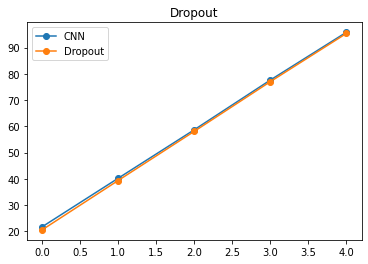

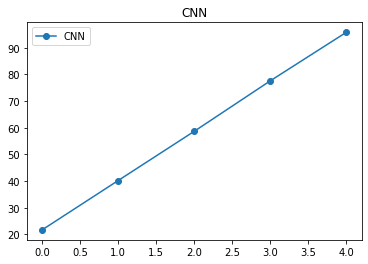

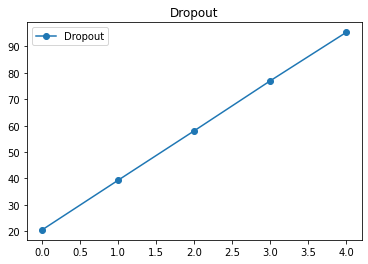

In [71]:
def visualize_train_time(df, names):
    _, ax = plt.subplots()
    for name in names:
        values = df[name].values
        values = values[values != '']  # yes, crappy code, i dont have a lot of time yet
        ax.plot(values, marker = 'o')
    ax.set_title(name)
    ax.legend(names)


visualize_train_time(training_time_df, names)

# For separate graphs
for name in names:
    visualize_train_time(training_time_df, [name])

## Full train time, seconds per epoch

[18.52231099999994, 18.480889000000047, 18.95587999999998, 18.226865999999973] <class 'float'>
[18.83054700000003, 18.72798599999998, 18.954500000000053, 18.384868999999966] <class 'float'>


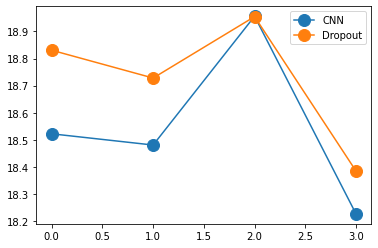

In [72]:
def visualize_time_per_epoch(df, names):
    fig, ax = plt.subplots()
    for name in names:
        time_series = df[name].values
        time_series = time_series[time_series != '']
        deltas = [time_series[i] - time_series[i-1] for i in range(1, len(time_series))]
        print(deltas, type(deltas[0]))
        ax.plot(deltas, marker = 'o', markersize = 12)

    ax.legend(names)


visualize_time_per_epoch(training_time_df, names)

## Test flow performance

In [73]:
if using_gpu:
    print(f'Fitting with GPU')
    with tf.device(device_name):
        metrics_dict = collect_metrics(models, test_flow, test_steps)
else:
    metrics_dict = collect_metrics(models, test_flow, test_steps)

69/69 [==============================] - 6s 74ms/step - loss: 8.5906 - acc: 0.5797


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


69/69 [==============================] - 5s 62ms/step - loss: 0.6703 - acc: 0.5217


In [74]:
def normalize_col(df, colnames):
    for c in colnames:
        df[c + '_norm'] = df[c] / np.max(df[c])

test_metrics_df = pd.DataFrame(metrics_dict).transpose()

normalize_col(
    test_metrics_df,
    [
        'data_eval_time_sec',
        'tr_params',
        'test_loss^(-1)'
    ]
)

In [75]:
test_metrics_df.head()

,data_eval_time_sec,data_size,test_loss^(-1),test_accuracy,F1,precision,recall,tr_params,data_eval_time_sec_norm,tr_params_norm,test_loss^(-1)_norm
CNN,10.704080,69.0,8.590555,0.579710,0.480721,0.423939,0.579710,10788643.0,1.00000,0.898974,1.000000
Dropout,5.422148,69.0,0.670273,0.521739,0.527273,0.536155,0.521739,12001059.0,0.50655,1.000000,0.078024


In [76]:
if saving_metrics_report:
    print(f'Saving metrics to {evaluation_path}')
    test_metrics_df.to_csv(evaluation_path + 'test_metrics_res.csv')

Saving metrics to /content/drive/MyDrive/UNIPD/HDA/Project/SavedModels/2022-01-29/trial-2/


<Figure size 1080x1080 with 0 Axes>

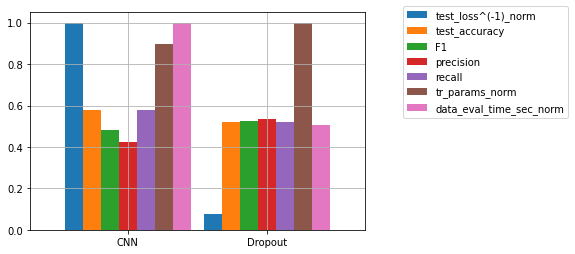

In [77]:
metrics_to_show = [
                   'test_loss^(-1)_norm',
                   'test_accuracy',
                   'F1',
                   'precision',
                   'recall',
                   
                   'tr_params_norm',
                   'data_eval_time_sec_norm'
]

plt.figure(figsize = (15, 15))
ax = test_metrics_df.loc[:, metrics_to_show].plot.bar(
    rot = 0,
    width = 0.9
)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

## Confusion matrices

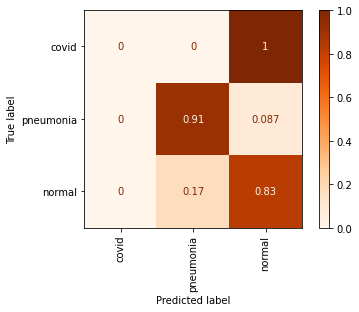

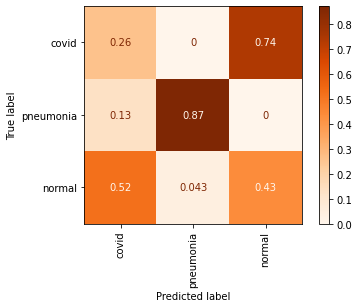

In [78]:
for m_name, model in models.items():
    test_flow.reset()
    plot_confusion_matrix(
        Y_true = test_flow.classes, 
        Y_pred = model.flow_predict(
            test_flow,
            test_steps
        ),
        class_indices = test_flow.class_indices
    )

## Learning curves

In [79]:
histories_path = f'{evaluation_path}/Histories/'
histories_dfs = {}

In [80]:
for name in names:
    file_path = f'{histories_path}{name}_history.csv'
    df = pd.read_csv(file_path)
    histories_dfs[name] = df

FileNotFoundError: ignored

In [ ]:
def plot_learning_curves(histories_dict):
    for name, df in histories_dict.items():
        _, ax = plt.subplots()

        acc = df['acc']
        val_acc = df['val_acc']
        ax.plot(acc, marker = 'o')
        ax.plot(val_acc, marker = 'o')
        ax.set_title(name)
        ax.legend(['acc', 'val_acc'])
        plt.grid()

plot_learning_curves(histories_dfs)

## Layers interpretation

In [ ]:
test_flow[0][0][0].shape, test_flow[0][1][0]
img_n = 3

In [ ]:
if 'CNN' in names:
    visualize_kernel_work(
        model = models['CNN'].model, 
        n_layer = 0, 
        n_kernel = 0, 
        
        image = test_flow[img_n][0][0],
        label = test_flow[img_n][1][0],  # 10th image 
        n_color_channels = PreprocessingParameters.n_color_channels[0]
    )

In [ ]:
if 'CNN' in names:
    visualize_kernel_work(
        model = models['CNN'].model, 
        n_layer = 2,
        n_kernel = 0, 

        image = test_flow[img_n][0][0],
        label = test_flow[img_n][1][0],
        n_color_channels = PreprocessingParameters.n_color_channels[0]
    )